### Investigation of Top Mass Reweighting

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

In [3]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [4]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [5]:
data_dir = 'DCTRFitting/'

In [6]:
default_had_mass = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]

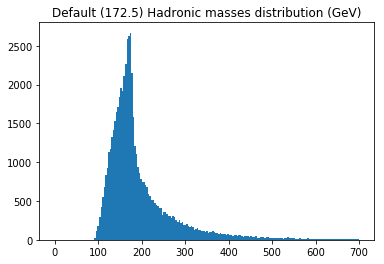

In [7]:
plt.hist(default_had_mass, bins = np.linspace(0,700,200))
plt.title("Default (172.5) Hadronic masses distribution (GeV)")
plt.show()

In [8]:
truth_had_mass = np.load(data_dir+ 'part_varmass_6j_obs.npy')[:,1][:len(default_had_mass)]

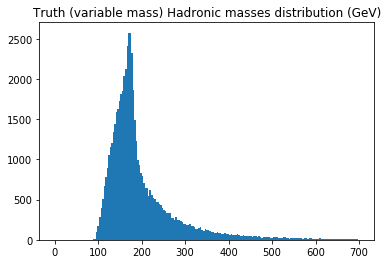

In [9]:
plt.hist(truth_had_mass, bins = np.linspace(0,700,200))
plt.title("Truth (variable mass) Hadronic masses distribution (GeV)")
plt.show()

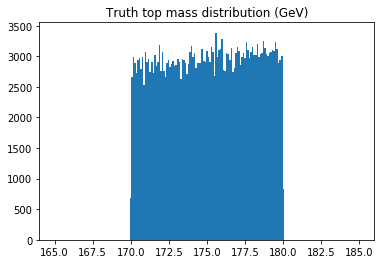

In [10]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]
plt.hist(mu_values, bins = np.linspace(165,185,200))
plt.title("Truth top mass distribution (GeV)")
plt.show()

In [11]:
mu_min = 170
mu_max = 180
mu_values = np.random.uniform(mu_min, mu_max, len(default_had_mass))
X0 = [(default_had_mass[i], mu_values[i]) for i in range(len(default_had_mass))]
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [12]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]
X1 = [(truth_had_mass[i], mu_values[i]) for i in range(len(truth_had_mass))]
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [13]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [15]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=20, 
          batch_size = 100,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 92336 samples, validate on 23084 samples
Epoch 1/20
92336/92336 [==============================] - 8s 86us/step - loss: 0.7949 - val_loss: 0.7105
Epoch 2/20
92336/92336 [==============================] - 5s 54us/step - loss: 0.7531 - val_loss: 1.1144
Epoch 3/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.7338 - val_loss: 0.7095
Epoch 4/20
92336/92336 [==============================] - 5s 51us/step - loss: 0.7293 - val_loss: 0.7158
Epoch 5/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.7187 - val_loss: 0.6964
Epoch 6/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.7121 - val_loss: 0.6951
Epoch 7/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.7046 - val_loss: 0.6937
Epoch 8/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.6976 - val_loss: 0.6975
Epoch 9/20
92336/92336 [==============================] - 5s 52us/step - loss: 0.6949 - val_loss: 0.6952
Epoch

In [16]:
X0_test = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]
X0_test = np.vstack([X0_test,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

In [17]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [18]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [19]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

0.96338445
1.0380073
0.96338445
1.0380073


In [38]:
weights_0.shape, X0_test.shape

((57710,), (57710, 2))

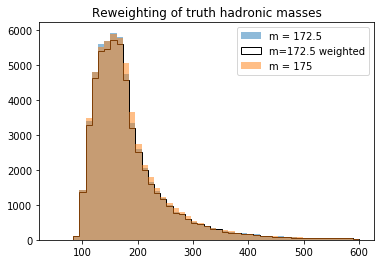

In [39]:
bins = np.linspace(50,600,50)
plt.title("Reweighting of truth hadronic masses")
plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5')
plt.hist(X0_test[:,0], bins = bins, label = 'm=172.5 weighted', weights=weights_0, histtype='step', color='k')
plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')
plt.legend()
plt.show()

In [40]:
X0_test = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,1]
X0_test = np.vstack([X0_test,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,1]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

In [41]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [42]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [43]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

0.96338445
1.0380073
0.96338445
1.0380073


In [44]:
weights_0.shape, X0_test.shape

((57710,), (57710, 2))

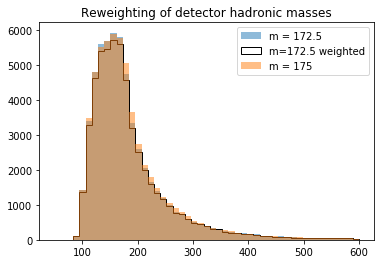

In [45]:
bins = np.linspace(50,600,50)
plt.title("Reweighting of detector hadronic masses")
plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5')
plt.hist(X0_test[:,0], bins = bins, label = 'm=172.5 weighted', weights=weights_0, histtype='step', color='k')
plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')
plt.legend()
plt.show()